<h1><center>Programming Exercise 4:<br>Neural Networks Learning</center></h1>

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.io import loadmat 
from scipy.misc import toimage
import random

mpl.rcParams['figure.figsize'] = (10,6)

# 1. Neural Networks (NN)
- In the previous exercise we implemented feedforward propagation for neural networks and used it to predict handwritten digits with the weights provided. Here, we will implement the backpropagation algorithm to learn the parameters for the NN

## 1.1 Visualizing the data
- Dataset of digit images is the same as last week's with the label "10" for the digit "0"

In [2]:
data1 = loadmat('ex4data1.mat')
# X is the design matrix of 5000 samples, 400 features for each
# Each sample actually comes from a 20 pixel by 20 pixel image (grayscale) thus comprises a 400-dimensional vector
# y is the output vector with class labels from 1-10; note that the 0 class has been mapped to the number 10 (this is to address an Octave/Matlab indexing issue)
X, y  = data1['X'], data1['y'].flatten() # flatten the second to make it a row vector (as our notational formalism expects)!!
X = np.c_[np.ones(np.shape(X)[0]),X] # add bias terms
np.place(y,y==10,0) # replace labeled 10's with 0's for all sample

- Recall from ex3 that to we need to flip them upsidedown and rotate them by 270 degrees to get the display right

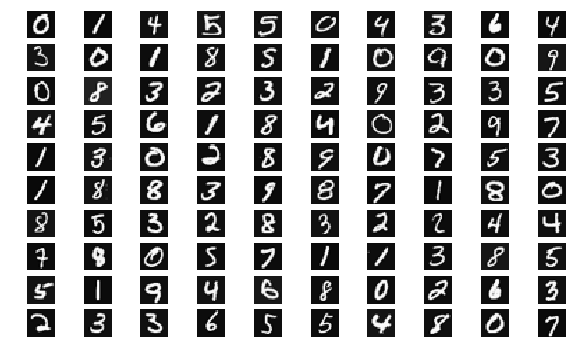

In [3]:
# Select 100 random indices and plot the samples
rand_ind = random.sample(range(0,X.shape[0]),100) # 100 random samples from given population (sequence)

# Save 100 random samples (reshaped into 20 by 20) in array
rand_sample_arr = np.array([np.flipud(np.reshape(X[ii_ind,1:],(20,20))) for ii_ind in rand_ind]) # ignoring the bias term

# Plot all images as subplots of one figure
plt.figure()
for ii_idx,ii_sample in enumerate(rand_sample_arr):
    ii_image = toimage(ii_sample)
    ii_image = ii_image.rotate(270)
    plt.subplot(10,10,ii_idx+1)
    plt.imshow(ii_image,cmap='Greys_r')
    plt.axis('off')
plt.show()

## 1.2 Model Representation
- As in ex3, we have a NN with 3 layers (input, hidden, and output) where the hidden layer has 25 activation units and the output has 10 units
- The network parameters $\Theta^{(1)}$ and $\Theta^{(2)}$ have already been trained and provided:

In [4]:
data2 = loadmat('ex4weights.mat')

theta1, theta2 = data2['Theta1'], data2['Theta2'] 

# Check shapes
print('theta1 shape is: {}'.format(np.shape(theta1)))
print('theta2 shape is: {}'.format(np.shape(theta2)))

theta1 shape is: (25, 401)
theta2 shape is: (10, 26)


## 1.3 Feedforward and Cost Function
- The NN cost function (cross-entropy loss) is:

$$
J(\Theta) = \frac{1}{m}\sum_{i=1}^m\sum_{k=1}^K \left[-y_k^{(i)}\log((h_\Theta(x^{(i)}))_k)-(1-y_k^{(i)})\log(1-(h_\Theta(x^{(i)}))_k)\right] + \frac{\lambda}{m}\sum_{l=1}^{L-1}\sum_{i=1}^{s_l}\sum_{j=1}^{s_{l+1}}\left(\Theta_{ji}^{(l)}\right)^2
$$

- Here we implement forward-prop and cost function w/o regularization
- Andrew NG recommended doing everything with for loops, however we already vectorized the forward prop procedure in ex3.ipynb (see Section 2 notes and `predict` function). We'll edit the `predict` function of ex3 here to give us back the (probability matrix) outputs rather than the label prediction

In [5]:
def forwardProp(theta1,theta2,X):
    '''
    Performs forward propagation to give output of a three-layer Neural Network with p
    (not counting bias) activation units in second layer (hidden) and K units in output 
    layer given the weight matrices of propagation Theta1 and Theta2 and design matrix 
    of samples X
    
    Parameters
    ----------
    theta1: p by (n+1) matrix of optimized thetas for transition between input layer and hidden layer
    theta2: K by (p+1) matrix of optimized thetas for transition between hidden layer and output layer
    X: m by (n+1) design matrix (includes bias units)
    
    Returns
    -------
    h: K by m matrix of probabilities for m samples to belong to K classes
    '''    
    
    # See ex3.ipynb Section 2 notes for explanation of procedures
    m = np.shape(X)[0] # sample size
    a2_matrix = sigmoid(theta1 @ X.T) # initial layer 2 activation units 
    bias_row = np.ones((1,m)) # bias term for second layer activation
    a2_matrix = np.vstack((bias_row,a2_matrix)) # insert bias term
    prob_matrix = sigmoid(theta2 @ a2_matrix) # Since this is the output, no bias term needs to be added for further computation
                                              # This is the matrix of probabilities, each colum for a sample
                                              # and a row for each class 0-9
    prob_matrix = np.roll(prob_matrix,1,axis=0) # shift entries in each column by 1, i.e colum [1,2,3] becomes [3,2,1]
                                                # see note in ex3.ipynb section 2 under definition of predict()
    return prob_matrix

- In Logistic Regression the cost function

$$
J(\theta)=\frac{-1}{m}\sum_{i=1}^m\left[y^{(i)}\log h_\theta(x^{(i)})+(1-y^{(i)})\log(1-h_\theta(x^{(i)}))\right]+\frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2
$$

has the vectorized form:

$$
J(\theta)=\frac{-1}{m}\left[Y^T\cdot\log g(X\cdot \theta)+(1-Y)^T\cdot\log(1-g(X\cdot \theta))\right]+\frac{\lambda}{2m}\theta^T[1:]\cdot\theta[1:]
$$

for $X$ of shape $m\times(n+1)$, $\theta$ of shape $(n+1)\times 1$, and $Y$ of shape $m\times1$. This makes $g(X\cdot \theta)$ of shape $m\times1$ which can then be dotted by $Y^T$ to give us the scalar value of $J(\theta)$. Note that what we do here is multiply the labeled value $y^{(i)}$ times the value the machine predicts $h_\theta(x^{(i)})$ for every sample and then we sum all these to compute the cost $J$
- In NN, the hypothesis $h_\Theta(X)$ is a matrix of shape $K\times m$ for $K$ classes and $m$ samples with a column per sample of form $a^{(3)}_{:,i}=[a^{(3)}_{i,1},a^{(3)}_{i,2},...,a^{(3)}_{i,K}]$. Also, the $y$ values are no longer scalars but vectors $y=[y_{i,1},y_{i,2},...,y_{i,K}]$ for sample $i$ where only one such value in the vector is 1 and the rest 0. Thus for all the samples have a matrix $Y$ of shape $K\times m$. For every sample, we have to sum the contributions to the cost for all classes $K$ (look at the form of the cost for NN above). Thus we are interested in taking the Hadamard (entrywise) product:

$$
Y\circ h_\Theta(X)
=
\begin{bmatrix}
a^{(3)}_{1,1}\cdot y_{1,1} & \dots & a^{(3)}_{m,1}\cdot y_{m,1} \\
\vdots & \ddots & \vdots \\
a^{(3)}_{1,K}\cdot y_{1,K} & \dots & a^{(3)}_{m,K}\cdot y_{m,K}
\end{bmatrix}
$$

of shape $K\times m$ where a column corresponds to a sample. Since, per sample (column), only one value of y will be 1 and the rest 0, this matrix collapses to a vector of shape $1\times m$. The final step is then to sum the entries of this vector to get the contribution to the cost $J$ from all samples
- For the regularization term, first note that the matrix of weights from layer $l$ with $s_l$ activation units to $l+1$ with $s_{l+1}$ activation units is:

$$
\Theta^{(l)}
=
\begin{bmatrix}
\Theta^{(l)}_{11} & \dots & \Theta^{(l)}_{1s_l} \\
\vdots & \ddots & \vdots \\
\Theta^{(l)}_{s_{l+1}1} & \dots & \Theta^{(l)}_{s_{l+1}s_l}
\end{bmatrix}.
$$

After expanding the regularization term in $J$ we can see that it is the sum of squares of every element of such a matrix's entries, and we do this for every $l$ there is. Note that since we don't regularize the bias term then for every matrix at layer $l$ we omit the first column $\Theta^{(l)}_{:,1}$ 
- If we define the vector $\mathbf{e}$ as a vector with 1's for all entries and of approrpiate size (into whatever matrix its multiplying into) then we can write the cost function for NN as:

$$
J(\Theta) = \frac{-1}{m}\mathbf{e}^T\cdot [Y\circ\log h_\Theta(X)]+(1-Y)\circ \log(1-h_\Theta(X))]\cdot\mathbf{e}+\frac{\lambda}{2m}\sum_{l=1}^{L-1}\mathbf{e}^T\cdot[\Theta^{(l)}\circ\Theta^{(l)}]\cdot\mathbf{e}
$$

where $h_\Theta(X)$ is the output of forward-prop. This encapsulates all the notes discussed here

- First let's get our $Y$ matrix:

In [14]:
y_matrix = np.zeros((10,np.shape(X)[0])) # initialize with zeros; of shape K=10 by m 
for ii_idy,ii_y in enumerate(y):
    y_matrix[ii_y,ii_idy] = 1 # set = 1 at the class label, i.e the index

- Now define the cost function:

In [72]:
def costFunction(theta_flat,design,y_matrix,reg_param=0):
    '''    
    Computes the cost function for a NN with architecture: 3 hidden layers, 25 activation units
    in hidden layer and 10 output units in final layer given a design matrix of shape m by 401,
    y matrix of shape K=10 by m with labels for the outputs.
    Returns the scalar J
    
    Parameters
    ----------
    theta_flat: array of length 10285 made up of values for transition matrices theta1 and theta2
    design: m by 401 design matrix
    output: K=10 by m output matrix
    reg_param (optional): scalar, regularization parameter; default is 0
    
    Returns
    -------
    costJ: scalar, value of the cost function
    '''
    
    m = np.shape(design)[0] # sample size
    
    # Recover thetas from flattened arrays:
    theta1 = np.reshape(theta_flat[:10025],(25,401)) 
    theta2 = np.reshape(theta_flat[10025:10285],(10,26)) 
    
    hypothesis = forwardProp(theta1,theta2,X)
    costJ_vector = -1/m*(y_matrix*np.log(hypothesis)+(1-y_matrix)*np.log(1-hypothesis)) # * is the Hadamard product
    reg_term = 0
    for ii_theta in [theta1,theta2]: # 3 layers so two transition matrices, this is the sum over l=1,...,L-1
        reg_term += np.sum(ii_theta[:,1:]*ii_theta[:,1:]) # ignore the bias terms
    costJ = np.sum(costJ_vector) + reg_param/(2*m)*reg_term

    return costJ

In [73]:
theta_flat = np.r_[np.ndarray.flatten(theta1),np.ndarray.flatten(theta2)]
costFunction(theta_flat,X,y_matrix,reg_param=0)

0.28762916516131887

boo yah! got it

## 1.4 Regularized Cost Function
- The full version of the cost function including regularization is implemented above so let's test it here:

In [74]:
costFunction(theta_flat,X,y_matrix,reg_param=1)

0.38376985909092359

got it again!

# 2. Backpropagation

## 2.1 Sigmoid Gradient

## 2.2 Random Initialization

## 2.3 Backpropagation

## 2.4 Gradient Checking

## 2.5 Regularized Neural Networks

## 2.6 Learning Parameters Using `fmincg`

# 3. Visualizing the Hidden Layer

## 3.1 Optional Exercise